# Clustering
In this notebook, we will use clustering to study a collection of Shakespeare plays and their genres. Note that this notebook is intended to be a useful reference for your Final Project.

## Importing Python modules and third-party packages

Import modules and methods. Instead of using hand-crafted clustering methods, we'll be using the implementations provided by [scikit-learn](https://scikit-learn.org/0.23/).

In [1]:
import os
import re
import numpy as np
from collections import Counter
from scipy.cluster.hierarchy import dendrogram

# Modules from scikit-learn
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

# Packages for plotting
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='white', font_scale=1.3) # Set the style for the plots

To check the version of an imported package, we can examine the `__version__` attribute. For example, the following cell prints the version of `sklearn` and the version of `numpy` used in this notebook.

In [2]:
import sklearn
print("scikit-learn: {}".format(sklearn.__version__))
print("numpy: {}".format(np.__version__))

scikit-learn: 0.23.2
numpy: 1.19.2


## Loading in & organizing our dataset

For a project, it is extremely useful to consider what data you need and the best forms (i.e. data structures) for this data to take. This might change as your analysis progress, but it's very useful to make these design choices in one central location so that it is easy to reference and update consistently.


In the next two cells, the following useful global variables are defined and constructed:
- `genres`: a list of working play genres
- `all_counts`: a Counter that stores the collection-level counts of each word type
- `doc_counts`: a Counter that stores the *document frequency* of each word type
- `play_data`: a list containing play-level data structures, one per play
- `play_index`: a dictionary that maps play titles to their corresponding index in `play_data`

Each play-level data structure is a *dictionary* with the following fields:
- `"title"`: the play's title
- `"genre"`: the play's genre
- `"counts"`: a Counter that stores the play's word type counts

In [3]:
# Play genres
genres = ['comedy', 'history', 'tragedy']

# This counter will store the total frequency of each word type
all_counts = Counter()
# This counter will store the document frequency of each word type
doc_counts = Counter()

# A list of play-level data structures, one for each play in the collection
play_data = []
# Play Index (by title)
play_index = {}

In [4]:
# Read in plays from files
word_pattern = re.compile("\w[\w\-\']*\w|\w")
genre_directories = {
    "comedy": "shakespeare/comedies",
    "history": "shakespeare/histories",
    "tragedy": "shakespeare/tragedies",
}

for genre, genre_directory in genre_directories.items():
    for filename in os.listdir(genre_directory):
        # Only read .txt files
        if filename.endswith('.txt'):
            # Initialize play-specific data structures
            play_counter = Counter()
            play_data.append({
                "title": filename[:-4],
                "genre": genre,
                "counts": play_counter,
            })
            play_index[filename[:-4]] = len(play_data)-1
            
            # Open and tokenize file
            filepath = '{}/{}'.format(genre_directory, filename)
            with open(filepath, encoding='utf-8') as reader: ## What encoding are the files in?
                for line in reader:
                    line = line.strip()
                    # Skipe empty and non-speaking lines
                    if line and not line.startswith('<'):
                        line = line.lower()
                        tokens = word_pattern.findall(line)
                        play_counter.update(tokens)
            # Update genre and overall counters
            doc_counts.update(play_counter.keys())
            all_counts += play_counter

`play_index` allows us to more easily find the metadata of a play by its title. For example, we can use it to look up the genre of *Anthony and Cleopatra* as follows:

In [5]:
# What's the genre of Anthony and Cleopatra?
idx = play_index['Anthony and Cleopatra']
play_map = play_data[idx]
print(play_map['genre'])

tragedy


## Building vectors

Now that we've loaded in the working collection, we can construct the vectors for each play. The dimensions of the vector will correspond to the frequencies of words in our vocabulary. To reduce the effects of document length, we'll normalize each vector by dividing its values by the total sum of its values. In other words, rather than our vectors representing counts, they'll represent probabilities.

Q: What similarity/distance measures does this normalization affect?

The first step in building our vectors, is deciding on our working vocabulary. For now, we'll use a simple curation method: we'll only include words occuring in more than one play. For this curation, we'll use `doc_count`.

In [6]:
vocabulary = []
for word_type, doc_count in doc_counts.most_common():
    if doc_count > 1:
        vocabulary.append(word_type)
print('Max Vocab Size: {}'.format(len(all_counts.keys())))
print('Current Vocab Size: {}'.format(len(vocabulary)))

Max Vocab Size: 27549
Current Vocab Size: 14245


As we can see above, this simple curation choice has dramatically reduced our vocabulary size. However, in practice we often will want to further reduce our working vocabulary to a smaller, more informative set. The exact set we're interested will depend on our question and analysis, but typically we care both about a word's overall frequency and document frequency.

Q: What happens if you use a different working vocabulary? How do the visualizations and clustering results change?

Now that we've decided on a vocabulary, we can build our play vectors. We'll store the computer vectors within `play_vectors` using the same play indices as `play_data`. Note that each vector is a [numpy array](https://numpy.org/doc/stable/reference/generated/numpy.array.html).

In [7]:
play_vectors = []
for struct in play_data:
    counts = struct['counts']
    vector = np.array([counts[w] for w in vocabulary])
    # Normalize vector's by their length
    vector = vector/vector.sum()
    play_vectors.append(vector)

For the purposes of this notebook, it'll be useful to have a list of the play genres such that its indices align with `play_vectors`. So, we'll construct `play_genres` a list of play genres using the same indices as `play_data`.

In [8]:
play_genres = [x['genre'] for x in play_data]

## Visualizing our dataset

Before getting into clustering it's useful to *visualize* our existing *vector space*. While we can't visualize 14,245 dimensions, we *can* view two-dimensional projections of this space.

To reduce our vectors to two dimensions, we'll use two different methods: (1) Truncated SVD and (2) t-SNE.
1. **Truncated SVD** identifies new dimensions that best capture the variation of the original dataset. This method works well with *sparse* vectors (i.e. many zeros) like our play vectors.
2. **t-sne** is a non-linear method for visualizing high-dimensional data that incorporates both local and global structure.

To visualize these two dimensional projections, we'll use seaborn's scatterplot visualization ([documentation](https://seaborn.pydata.org/generated/seaborn.scatterplot.html)). While we shouldn't read too much into the exact positioning of vectors (e.g. points) within the space, it can give us some insight into how our vectors cluster.

### Truncated SVD

We'll use the `TruncatedSVD` implementation provided by scikit-learn ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)).

There are conceptually three steps occurring in the following code. First, we initialize an *untrained* Truncated SVD model. Then we will "train" this model using `play_vectors` with the `fit` method. Finally, we'll generate our two-dimensional projections using the `transform` function.

In [9]:
# Create initial model
svd_model = TruncatedSVD(n_components=2)
# Fit model using the play_vectors as training data
svd_model.fit(play_vectors)
# Train model on specified vectors, then return their lower-dimensional projections
vectors_2d = svd_model.transform(play_vectors)

Now, we can create a scatterplot of these two-dimensional vectors using seaborn.

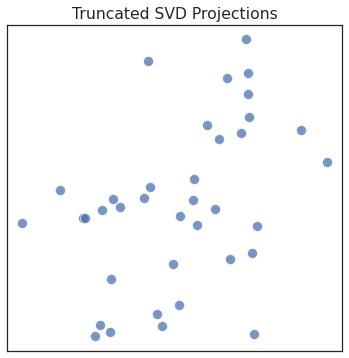

In [10]:
# Create figure with specified size
plt.figure(figsize=(6,6))

# Create Scatterplot
# x = list of x-coordinates 
# y = list of y-coordinates
# s = for adjusting size of points
# alpha = for adjusing transluceny of points
_ = sns.scatterplot(x=vectors_2d[:, 0], y=vectors_2d[:, 1], s=100, alpha=.75)
# Create title
plt.title("Truncated SVD Projections")
# Hide x- and y- axis labels since we don't care about these values
_ = plt.xticks([])
_ = plt.yticks([])

While it looks like there might be some clustering in the above plot, we need more *context* to make any sense of it. So, we'll color these points by their respective genres. The colors used is determined by the specified color palette. We'll be using `tab10` which provides 10 visually distinct colors. For more on color palettes, see this [page](https://seaborn.pydata.org/tutorial/color_palettes.html).



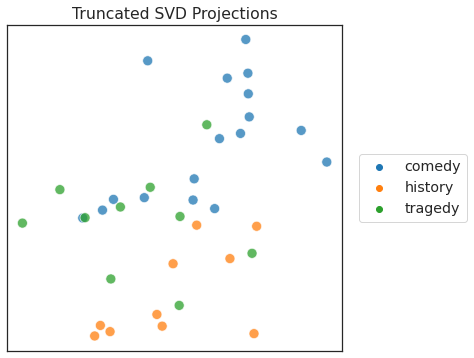

In [11]:
# Create figure with specified size
plt.figure(figsize=(6,6))

# Create Scatterplot
# hue = specifies the labels used to determine coloring
# palette = specifies the color palette to use
_ = sns.scatterplot(x=vectors_2d[:, 0], y=vectors_2d[:, 1], s=100, alpha=.75,
                   hue=play_genres, palette='tab10')

# This repositions the figure's legend
_ = plt.legend(loc="center left", bbox_to_anchor=(1.05, .5),borderaxespad=0)

# Create title
plt.title("Truncated SVD Projections")
# Hide x- and y- axis labels since we don't care about these values
_ = plt.xticks([])
_ = plt.yticks([])

From this plot we can see that many of the comedy plays seem to be grouped together *and* separated from the other genres. While tragedy and history plays also seem to be somewhat spatially clustered, this genre clustering is not as distinct (i.e. there is a lot of mixing of genres).

### t-SNE

Now, we'll try visualizing with t-SNE. We'll use the `TSNE` implementation provided by scikit-learn ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)).

While the core steps for constructing two-dimensional t-SNE projections will be very similar to Truncated SVD. There are a few more things to keep in mind.
1. For extremely high-dimensional data, we typically use a *different* method to reduce to 50-dimensional vectors first which we will then use as input to t-SNE. We'll go ahead an use Truncated SVD for this.
2. t-SNE has a few hyperparameters that can dramatically affect the resulting visualization. For `TSNE` these are `perplexity` and `learning_rate`. Generally, try using the default values, but if the resulting plots look strange it might be worth changing these values. To learn more take a look at the `TSNE` documentation as well as this [blog post](https://distill.pub/2016/misread-tsne/).

In [12]:
# First, reduce the points to 50 or fewer dimensions.
# Since we only have 37, points we'll reduce ours to 37-dimensions.
vectors_37d = TruncatedSVD(n_components=37).fit_transform(play_vectors)

# Create initial model
tsne_model = TSNE(n_components=2, perplexity=5)
# Unlike TruncatedSVD there's no separate "transform" function only "fit_transorm".
# This is because the t-sne embeddings are specific to the set of vectors.
vectors_2d = tsne_model.fit_transform(vectors_37d)

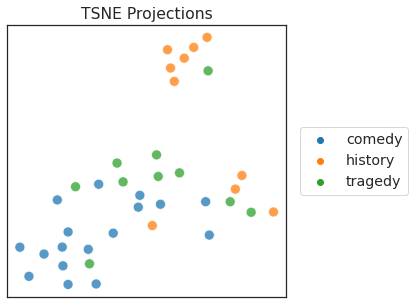

In [13]:
# Create figure with specified size
plt.figure(figsize=(5,5))

# Create Scatterplot
# hue = specifies the labels used to determine coloring
# palette = specifies the color palette to use
_ = sns.scatterplot(x=vectors_2d[:, 0], y=vectors_2d[:, 1], s=100, alpha=.75,
                   hue=play_genres, palette='tab10')

# This repositions the figure's legend
_ = plt.legend(loc="center left", bbox_to_anchor=(1.05, .5),borderaxespad=0)

# Create title
plt.title("TSNE Projections")
# Hide x- and y- axis labels since we don't care about these values
_ = plt.xticks([])
_ = plt.yticks([])

Using t-SNE we also see some evidence of genre clustering. While these are not conclusive results on their own, they suggest that our given feature vectors are capturing some aspects of genre that should be measurable by clustering and classificaiton.

## Clustering

Now that we've examined two-dimensional representations of our vector space. Let's see what kind of clusters are identified using agglomerative clustering and k-means clustering.

To "visualize" our results. We'll use the following two functions:
1. `print_clusters`takes a list of cluster labels as input and prints the plays (genre & title) of each cluster.
2. `plot_clusters` produces a 2D visualization (Truncated SVD) of the play vector points. A point's color is based on its cluster assignment, it's shape the play's genre. Optionally, the k-means centroids can also be added to the plot.

In [14]:
def print_clusters(cluster_labels):
    n_clusters = max(cluster_labels) + 1
    
    # Group cluster indices
    cluster_indices = [[] for i in range(n_clusters)]
    for i, label in enumerate(cluster_labels):
        cluster_indices[label].append(i)
    
    # Print clusters
    for cluster_id in range(n_clusters):
        print("Cluster {}".format(cluster_id))
        
        for play_id in cluster_indices[cluster_id]:
            struct = play_data[play_id]
            print("  {} - {}".format(struct["genre"], struct["title"]))

In [15]:
def plot_clusters(vectors, cluster_labels, centroids=None):
    svd_model = TruncatedSVD(n_components=2)
    vectors_2d = svd_model.fit_transform(play_vectors)
    
    # Check number of labels
    if cluster_labels is not None and len(set(cluster_labels)) > 10:
        print("Warning: this plot only uses 10 colors for clusters, so there will be color reuse")
    
    # Plot 2d vectors
    plt.figure(figsize=(6,6))
    _ = sns.scatterplot(x=vectors_2d[:, 0], y=vectors_2d[:, 1], style=play_genres,
                        hue=cluster_labels, palette='tab10',
                        s=100, alpha=.75)
    _ = plt.legend(loc="center left", bbox_to_anchor=(1.05, .5),borderaxespad=0)
    _ = plt.xticks([])
    _ = plt.yticks([])
    
    # Plot centroids, if provided
    if centroids is not None:
        hues = sns.color_palette('tab10')
        centroids_2d = svd_model.transform(centroids)
        for i in range(centroids_2d.shape[0]):
            hue = hues[i % 10]
            plt.scatter(x=[centroids_2d[i, 0]], y=[[centroids_2d[i, 1]]],
                        marker='*', color=hue, s=300)

### Agglomerative Clustering
We'll use the `AgglomerativeClustering` implementation provided by `scikit-learn` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)).

As we discussed last week there are two important choices in agglomerative clustering that will need to be specified for `AgglomerativeClustering:
1. `affinity`: What distance measure we use to compare vector points.
2. `linkage`: How we measure the distance between two clusters.

For this implementation there are two main training modes:
1. Specifiy the desired number of clusters using `n_clusters`.
2. Instead specify a distance threshold `distance_threshold` such that clusters with a distance above this threshold will not be merged. In this scenario, we'll also need to explicitly set `n_clusters` to `None`.

For agglomerative clustering, we're often interested in collectively examining the hierarchies of clusters created through the iterative merging process. We can visualize this using a *dendrogram* plot after we've performed agglomerative clustering such that we form a *single* cluster of all the vectors.

We can use the function `plot_dendrogram` to plot a dendrogram, but we'll need to train our `AgglomerativeClustering` model in a specific way to do so. Namely, we'll need to set `distance_threshold` to `0` and `n_clusters` to `None`.

References:
- [Plot Hierarchical Clustering Dendrogram](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html)

In [37]:
# Code taken from "Plot Hierarchical Clustering Dendrogram"
def plot_dendrogram(model,  **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

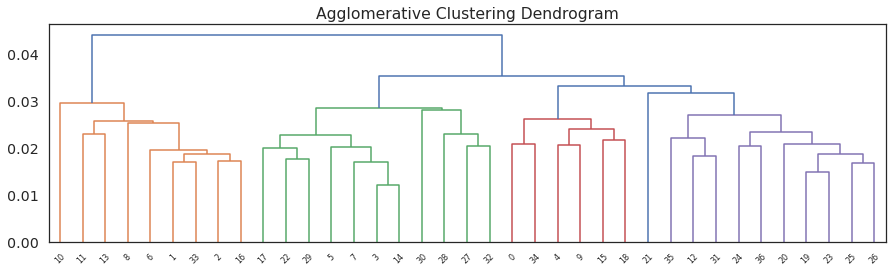

In [42]:
plt.figure(figsize=(15,4)) # Specifies the figure size of the plot.

agglom_model = AgglomerativeClustering(n_clusters=None, distance_threshold=0, affinity='euclidean', linkage='complete', )
agglom_model.fit(play_vectors)

plot_dendrogram(agglom_model)

_ = plt.title('Agglomerative Clustering Dendrogram')

We can further change how this dendrogram plot looks by providing `plot_dendrogram` named arguments for SciPy's `dendrogram` function ([documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html)).
For example, we can rotate the node labels (i.e. x-axis labels) using `leaf_rotation`, change the node labels' font size using `leaf_font_size`, and even the text used for these node labels using `labels` (labels need to follow the same order as the vectors that were clusters).

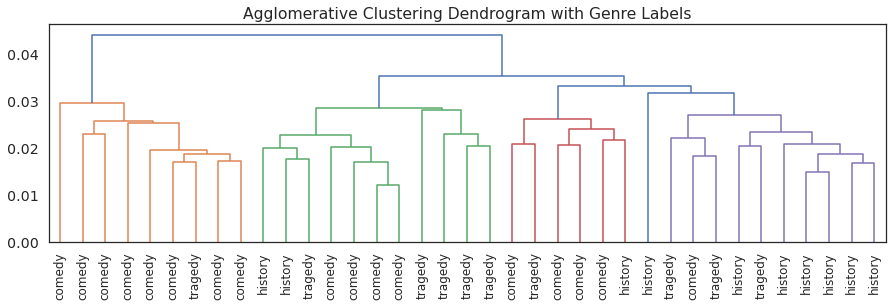

In [52]:
plt.figure(figsize=(15,4))
plot_dendrogram(agglom_model, leaf_rotation=90, leaf_font_size=12, labels=play_genres)
_ = plt.title('Agglomerative Clustering Dendrogram with Genre Labels')

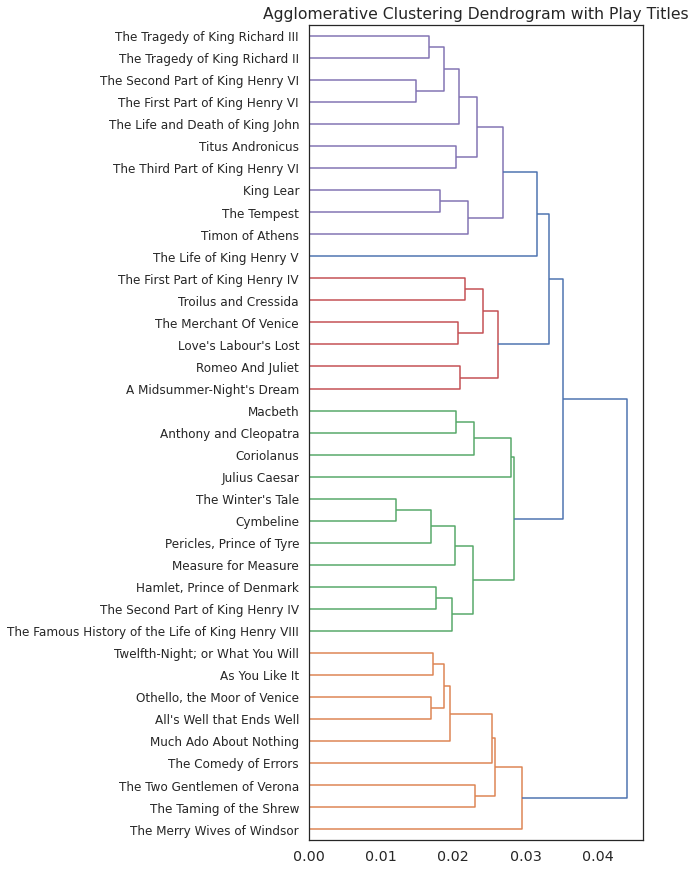

In [58]:
plt.figure(figsize=(6, 15))
plot_dendrogram(agglom_model, orientation='right', leaf_rotation=0, leaf_font_size=12, labels=[x['title'] for x in play_data])
_ = plt.title('Agglomerative Clustering Dendrogram with Play Titles')

Form the above dendrograms, we can see that there seem to be three core clusters. So, let's directly learn three cluster using `AggomerativeClustering` by setting `n_clusters`. We can examine our results using `print_clusters` and `plot_clusters`.

In [60]:
agglom = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')
agglom_labels = agglom.fit_predict(play_vectors)

In [61]:
print_clusters(agglom_labels)

Cluster 0
  comedy - A Midsummer-Night's Dream
  comedy - Love's Labour's Lost
  comedy - The Merchant Of Venice
  comedy - The Tempest
  comedy - Troilus and Cressida
  history - The First Part of King Henry IV
  history - The First Part of King Henry VI
  history - The Life and Death of King John
  history - The Life of King Henry V
  history - The Second Part of King Henry VI
  history - The Third Part of King Henry VI
  history - The Tragedy of King Richard II
  history - The Tragedy of King Richard III
  tragedy - King Lear
  tragedy - Romeo And Juliet
  tragedy - Timon of Athens
  tragedy - Titus Andronicus
Cluster 1
  comedy - All's Well that Ends Well
  comedy - As You Like It
  comedy - Much Ado About Nothing
  comedy - The Comedy of Errors
  comedy - The Merry Wives of Windsor
  comedy - The Taming of the Shrew
  comedy - The Two Gentlemen of Verona
  comedy - Twelfth-Night; or What You Will
  tragedy - Othello, the Moor of Venice
Cluster 2
  comedy - Cymbeline
  comedy - Mea

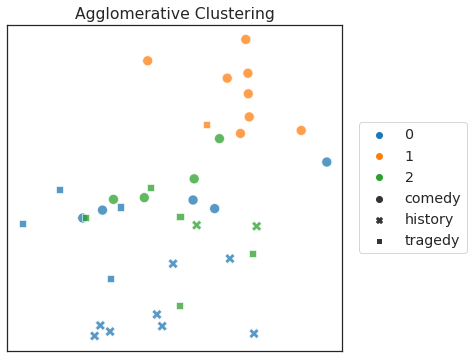

In [62]:
plot_clusters(play_vectors, agglom_labels)
_ = plt.title("Agglomerative Clustering")

Q: How do these clusters line up with the play genres?

### K-Means Clustering
We'll use the `KMeans` implementation provided by `scikit-learn` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)). Unlike `AggomerativeClusteing`, we'll only need to specify the number of clusters we want the algorithm to identify using `n_clusters`.

In [76]:
kmeans = KMeans(n_clusters=3)
kmeans_labels = kmeans.fit_predict(play_vectors)
centroids = kmeans.cluster_centers_

In [77]:
print_clusters(kmeans_labels)

Cluster 0
  history - The First Part of King Henry IV
  history - The First Part of King Henry VI
  history - The Life and Death of King John
  history - The Life of King Henry V
  history - The Second Part of King Henry VI
  history - The Third Part of King Henry VI
  history - The Tragedy of King Richard II
  history - The Tragedy of King Richard III
  tragedy - Titus Andronicus
Cluster 1
  comedy - A Midsummer-Night's Dream
  comedy - Cymbeline
  comedy - Love's Labour's Lost
  comedy - Pericles, Prince of Tyre
  comedy - The Tempest
  comedy - The Winter's Tale
  comedy - Troilus and Cressida
  history - The Famous History of the Life of King Henry VIII
  history - The Second Part of King Henry IV
  tragedy - Anthony and Cleopatra
  tragedy - Coriolanus
  tragedy - Hamlet, Prince of Denmark
  tragedy - Julius Caesar
  tragedy - King Lear
  tragedy - Macbeth
  tragedy - Romeo And Juliet
  tragedy - Timon of Athens
Cluster 2
  comedy - All's Well that Ends Well
  comedy - As You Like

Q: How do these k-means clusters line up wiith play genres?

 After we've run the model using `fit` or `fit_predict`, we can extract the learned centroids via the `cluster_centers_` attribute. We can visualize the centroids along with their clusterings using `plot_clusters`.

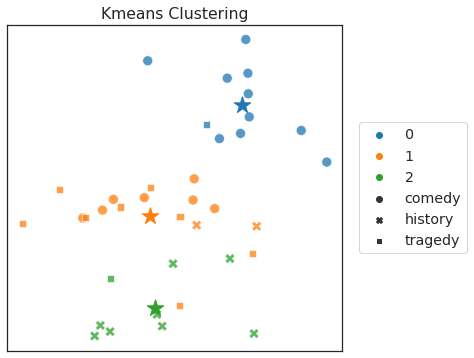

In [72]:
plot_clusters(play_vectors, kmeans_labels, centroids=centroids)
_ = plt.title("Kmeans Clustering")

Q: How has visualization, agglomerative clustering, and k-means clustering improved your understanding of this collection and its computational representation? Similarly, how have they improved your understanding of play genres?